# Preparing data
Prediction of sales is the central task in this challenge. you want to predict daily sales in various stores up to 6 weeks ahead of time. This will help the company plan ahead of time. 

The following steps outline the various sub tasks needed to effectively do this: 


In [35]:
# importing of libraries
import numpy as np
import pandas as pd
import librosa
import warnings
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import plotly.io as pio
from IPython.display import Image
import plotly.express as px

import os,sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from timeseries import TimeSeries
from clean import Clean
cleaner = Clean()

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

2022-05-30 23:46:12,169:logger:Successfully initialized clean class


In [19]:
PATH_TRAIN_TEXT = "../data/amharic_train_text.txt"
PATH_TRAIN_WAV = "../data/amharic_train_wav/"
PATH_TEST_TEXT = "../data/amharic_test_text.txt"
PATH_TEST_WAV = "../data/amharic_test_wav/"

In [20]:
train_labels = os.listdir(PATH_TRAIN_WAV)
test_labels = os.listdir(PATH_TEST_WAV)
train_labels = [i.strip('.wav') for i in train_labels]
test_labels = [i.strip('.wav') for i in test_labels]
print(f"Total number of training data: {len(train_labels)}")
print(f" Total number of testing data: {len(test_labels)}")

Total number of training data: 10875
 Total number of testing data: 359


# Preprocessing
It is important to process the data into a format where it can be fed to a machine learning model.

## Create Meta Data

In [21]:
text_data, label_data = cleaner.read_data(PATH_TRAIN_TEXT, PATH_TEST_TEXT, train_labels, test_labels)

2022-05-30 23:40:50,497:logger:Successfully read the data


In [22]:
print(f"Total Amharic training data: {len(text_data)}")

print(f" Total Amharic testing data: {len(label_data)}")

Total Amharic training data: 11234
 Total Amharic testing data: 11234


In [23]:
data = pd.DataFrame({'key': label_data, 'text': text_data})
data[:5]

,key,text
0,tr_10000_tr097082,የተለያዩ የ ትግራይ አውራጃ ተወላጆች ገንዘባቸው ን አዋጥ ተው የ ልማት ...
1,tr_10001_tr097083,የ ጠመንጃ ተኩስ ተከፈተ ና አራት የኤርትራ ወታደሮች ተገደሉ
2,tr_10002_tr097084,ላነሷቸው ጥያቄዎች የ ሰጡት ን መልስ አቅርበ ነዋል
3,tr_10003_tr097085,እ ብዱ አስፋልቱ ላይ የ ኰለኰ ለ ው ድንጋይ መኪና አላ ሳልፍ አለ
4,tr_10004_tr097086,ጠጁ ን ኰ መኰ መ ኰ መኰ መ ና ሚስቱ ን ሲ ያሰቃ ያት አደረ


In [24]:
duration_of_recordings = cleaner.get_duration(PATH_TRAIN_WAV, PATH_TEST_WAV, label_data)

2022-05-30 23:40:59,064:logger:The audio files duration is successfully computed


In [25]:
data["duration"] = duration_of_recordings

In [26]:
y = [x in test_labels for x in data.key]
data["category"] = ["Test" if i else "Train" for i in y]
data[:5]

,key,text,duration,category
0,tr_10000_tr097082,የተለያዩ የ ትግራይ አውራጃ ተወላጆች ገንዘባቸው ን አዋጥ ተው የ ልማት ...,9.088,Train
1,tr_10001_tr097083,የ ጠመንጃ ተኩስ ተከፈተ ና አራት የኤርትራ ወታደሮች ተገደሉ,5.632,Train
2,tr_10002_tr097084,ላነሷቸው ጥያቄዎች የ ሰጡት ን መልስ አቅርበ ነዋል,6.144,Train
3,tr_10003_tr097085,እ ብዱ አስፋልቱ ላይ የ ኰለኰ ለ ው ድንጋይ መኪና አላ ሳልፍ አለ,5.760,Train
4,tr_10004_tr097086,ጠጁ ን ኰ መኰ መ ኰ መኰ መ ና ሚስቱ ን ሲ ያሰቃ ያት አደረ,5.376,Train


In [27]:
y = [x in test_labels for x in data.key]
data["category"] = ["Test" if i else "Train" for i in y]
data[:5]

,key,text,duration,category
0,tr_10000_tr097082,የተለያዩ የ ትግራይ አውራጃ ተወላጆች ገንዘባቸው ን አዋጥ ተው የ ልማት ...,9.088,Train
1,tr_10001_tr097083,የ ጠመንጃ ተኩስ ተከፈተ ና አራት የኤርትራ ወታደሮች ተገደሉ,5.632,Train
2,tr_10002_tr097084,ላነሷቸው ጥያቄዎች የ ሰጡት ን መልስ አቅርበ ነዋል,6.144,Train
3,tr_10003_tr097085,እ ብዱ አስፋልቱ ላይ የ ኰለኰ ለ ው ድንጋይ መኪና አላ ሳልፍ አለ,5.760,Train
4,tr_10004_tr097086,ጠጁ ን ኰ መኰ መ ኰ መኰ መ ና ሚስቱ ን ሲ ያሰቃ ያት አደረ,5.376,Train


## Transcription of the Data

In [34]:
words_in_data = pd.DataFrame(' '.join(data['text']).split())
words_in_data.columns = ['word']
words_data = words_in_data.groupby(['word']).agg({'word': 'count'})
words_data.columns = ['counts']
words_data.reset_index(inplace=True)
words_data = words_data.sort_values("counts", ascending=False)
words_data.head(10)

,word,counts
11779,የ,7952
4889,በ,6570
7746,ን,6470
7704,ና,3238
2708,ም,2958
305,ለ,2529
7571,ነው,2477
9359,ኢትዮጵያ,2160
10273,ከ,1982
9830,እንደ,1080


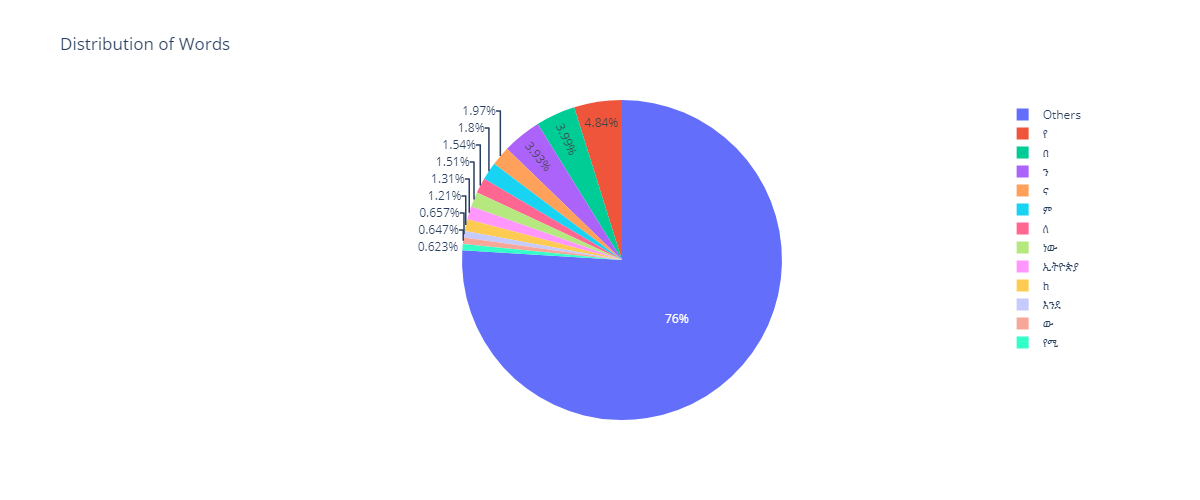

In [36]:
words_data.loc[words_data['counts'] < 1000, 'word'] = 'Others'
fig = px.pie(words_data, values='counts', names='word', title='Distribution of Words', width=800, height=500)
Image(pio.to_image(fig, format='png', width=1200))

Feature Engineering

In [ ]:
daily_sales = clean_df.aggregations(train,'Store','Sales','Open','sum')
daily_customers = clean_df.aggregations(train,'Store','Customers','Open','sum')
avg_sales = clean_df.aggregations(train,'Store','Sales','Open','mean')
avg_customers = clean_df.aggregations(train,'Store','Customers','Open','mean')
train['DailySales'] = train['Store'].map(daily_sales)
train['DailyCustomers'] = train['Store'].map(daily_customers)
train['AvgSales'] = train['Store'].map(avg_sales)
train['AvgCustomers'] = train['Store'].map(avg_customers)

For feature engineering the columns that are necessary for this particular analysis are;
- DailySales - this is an aggregation of the daily sales per store
- DailyCustomer - this is an aggregation of the daily customers per store
- AvgSales - this is an aggregation of the average sales per store
- AvgCustomers - this is an aggregation of the average customers per store

Why are these features necessary?. It is because the weight of the information is on the sales, because we are doing sales predictions and that the relationship between the customers and the sales is a positive linear relationship, therefore it shall come in handy in the predictions

Label Encoding

In [ ]:
clean_df.label_encoding(train,test)

2022-05-25 04:46:59,750:logger:Successfully stored the features
2022-05-25 04:47:00,279:logger:Successfully encoded your categorical data


The encoding that we do for the categorical data features is we use the factorize method, which encodes each element of the data to a coresponding integer

Scaling Data

In [ ]:
training_data_ = train[train.columns.difference(['DayOfWeek','Day', 'Month', 'Year', 'DayOfYear','WeekOfYear'])]
testing_data_ = test[test.columns.difference(['DayOfWeek','Day', 'Month', 'Year', 'DayOfYear','WeekOfYear'])]

In [ ]:
train_transformation=clean_df.generate_transformation(training_data_,"numeric","number")
test_transformation=clean_df.generate_transformation(testing_data_,"numeric","number")

2022-05-25 04:47:00,646:logger:Successfully transformed numerical data
2022-05-25 04:47:00,664:logger:Successfully transformed numerical data


In [ ]:
indexes = ['DayOfWeek','Day', 'Month', 'Year', 'DayOfYear','WeekOfYear']
train_transformed = pd.DataFrame(train_transformation,columns=train.columns.difference(indexes))
test_transformed = pd.DataFrame(test_transformation,columns=test.columns.difference(indexes))
train_index = train[indexes]
test_index = test[indexes]
train = pd.concat([train_index,train_transformed],axis=1)
test = pd.concat([test_index,test_transformed],axis=1)

For the transformations of our data we realize that the minmaxscaler because we want to ensure that when doing the backpropagation it shall be more stable,also it shall help our code to run faster when placing it.

In [ ]:
train.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
test.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

In [ ]:
train.to_csv("../data/cleaned_train.csv",index=False)
test.to_csv("../data/cleaned_test.csv",index=False)